In [12]:
import numpy as np
import heapq

def dijkstra_path(graph_adj, source, target):
    """
    Compute shortest distance from source to target using Dijkstra's algorithm.
    graph_adj: dict {node: list of (neighbor, weight)}
    """
    dist = {u: float('inf') for u in graph_adj}
    dist[source] = 0.0
    pq = [(0.0, source)]

    while pq:
        d, u = heapq.heappop(pq)
        if d > dist[u]:
            continue
        if u == target:
            break
        for v, w in graph_adj[u]:
            nd = d + w
            if nd < dist[v]:
                dist[v] = nd
                heapq.heappush(pq, (nd, v))
    return dist[target]

def gbm_step(prev_vals, mus, sigmas, dt):
    """
    One step of Geometric Brownian Motion for all edges.
    prev_vals: current weights (numpy array)
    mus: drift (numpy array)
    sigmas: volatility (numpy array)
    dt: time step
    """
    z = np.random.normal(size=prev_vals.shape)
    return prev_vals * np.exp((mus - 0.5 * sigmas**2) * dt + sigmas * np.sqrt(dt) * z)

def simulate_shortest_path_over_time(n_nodes, edge_list, source, target,
                                     T=1.0, dt=0.02, trials=200, seed=None):
    """
    Simulate expected shortest path length when edge weights evolve via GBM.
    
    edge_list: list of (u, v, init_weight, mu, sigma)
    Returns:
        times: array of time points
        mean_lengths: expected shortest path length at each time
        var_lengths: variance across trials
    """
    if seed is not None:
        np.random.seed(seed)

    n_steps = int(np.ceil(T / dt))
    times = np.linspace(0, T, n_steps+1)

    edges_u = np.array([e[0] for e in edge_list], dtype=int)
    edges_v = np.array([e[1] for e in edge_list], dtype=int)
    init_vals = np.array([e[2] for e in edge_list], dtype=float)
    mus = np.array([e[3] for e in edge_list], dtype=float)
    sigmas = np.array([e[4] for e in edge_list], dtype=float)

    lengths = np.zeros((trials, n_steps+1))

    for t_idx in range(trials):
        edge_vals = init_vals.copy()
        
        # Time 0 adjacency
        adj = {i: [] for i in range(n_nodes)}
        for i, (u, v) in enumerate(zip(edges_u, edges_v)):
            adj[u].append((v, edge_vals[i]))
            adj[v].append((u, edge_vals[i]))
        lengths[t_idx, 0] = dijkstra_path(adj, source, target)

        # Time evolution
        for k in range(1, n_steps+1):
            edge_vals = gbm_step(edge_vals, mus, sigmas, dt)
            
            adj = {i: [] for i in range(n_nodes)}
            for i, (u, v) in enumerate(zip(edges_u, edges_v)):
                adj[u].append((v, edge_vals[i]))
                adj[v].append((u, edge_vals[i]))
            
            lengths[t_idx, k] = dijkstra_path(adj, source, target)

    mean_lengths = np.mean(lengths, axis=0)
    var_lengths = np.var(lengths, axis=0)

    return times, mean_lengths, var_lengths

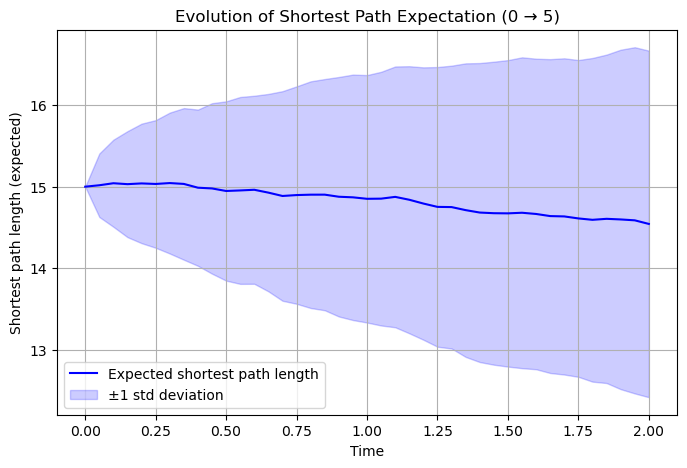

In [13]:
import matplotlib.pyplot as plt

# Example graph with 6 nodes
n_nodes = 6
edge_list = [
    (0, 1, 5.0, 0.0, 0.2),
    (1, 2, 3.0, 0.0, 0.3),
    (0, 3, 8.0, 0.1, 0.1),
    (3, 4, 2.0, 0.0, 0.25),
    (4, 5, 6.0, 0.0, 0.2),
    (2, 5, 10.0, 0.0, 0.3),
    (1, 4, 4.0, 0.05, 0.15),
]

# Run simulation
times, mean_lengths, var_lengths = simulate_shortest_path_over_time(
    n_nodes, edge_list, source=0, target=5,
    T=2.0, dt=0.05, trials=500, seed=42
)

# Plot evolution
plt.figure(figsize=(8,5))
plt.plot(times, mean_lengths, label="Expected shortest path length", color="blue")
plt.fill_between(times,
                 mean_lengths - np.sqrt(var_lengths),
                 mean_lengths + np.sqrt(var_lengths),
                 color="blue", alpha=0.2, label="±1 std deviation")

plt.xlabel("Time")
plt.ylabel("Shortest path length (expected)")
plt.title("Evolution of Shortest Path Expectation (0 → 5)")
plt.legend()
plt.grid(True)
plt.show()